# Descirption of the project

# Imports

In [1]:
import prophet
from fbprophet import Prophet
import sys
import os
import sys
import os
import pandas as pd
import numpy as np
from prophet.plot import plot
import matplotlib.pyplot as plt
from datetime import date

C:\Users\Ania\anaconda3\envs\prophet-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


# Global Variables


In [2]:

X_train_T2_path ='C:/Users/Ania/Desktop/Nestle Case/X_train_T2.csv'
y_train_T2_path = 'C:/Users/Ania/Desktop/Nestle Case/y_train_T2.csv'
y_test_T2_path = 'C:/Users/Ania/Desktop/Nestle Case/y_test_T2.csv'

sep = ';'
decimal = ','


# Reading data with use of Data Cleaning

In [3]:
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path+"\\DataCleaningProgram")
    
from data_loader import DataLoader

dl = DataLoader(coefficient_nulls_removal=50,
                date_column_name=['date'],
                outliers_columns=['channel_2','channel_15','channel_17', 'channel_18',
                                   'channel_20','channel_29','channel_43','channel_45',
                                   'channel_52','channel_57','channel_75','channel_89',
                                   'channel_95','channel_101','channel_111'],
                datetime_duplicated_column_name = ['date_Duplicated'])


X_train_T2 = dl.get_initial_data(input_data_path=X_train_T2_path, sep=sep, decimal=decimal)
y_train_T2 = dl.get_initial_data(input_data_path=y_train_T2_path,sep=sep, decimal=decimal)
y_test_T2 = dl.get_initial_data(input_data_path=y_test_T2_path, sep=sep, decimal=decimal)
print(f"X_train_T2: {len(X_train_T2)}")

C:\Users\Ania\git\DataScienceProject
X_train_T2: 791


# Creating merged file: X_train_T2 and y_train_T2 files  (input required)

# It will serve to conduct:

##  1. Single product analysis 
##  2. Additional regressors analysis

In [4]:
#merging two files X_train_T2 and y_train_T2 to obtain multichannel inputs for forecasts. 
#This file will be used for multiple regressors
data = pd.merge(left=X_train_T2, right=y_train_T2, on=['key', 'date'], how='inner')

#Adjust date in text file to be able to display in plots. Date in forecast and test files must have the same format.
data = dl.parse_dates(data)

#ad 'ds'
data['ds'] = data['date'] 

# Delete channels with >= 80% of data = NaNs
data = dl.remove_missing_data(data)
# print(data)

for channel in data.columns:
    data[channel].fillna(data[channel].mean(), inplace=True)
    
    if data[channel].isna().any():
        print('The column contains NaN values.')
    else:
        print('The column does not contain NaN values.')
        
print(data)

#Create list of products
product_list = pd.unique(data['key'])

#First product
#YOUR INPUT IS NEEDED: select index of the product that will be analysed further. 
#The final forecast for this product will be saved in a file y_test_T2. 
product_number = product_list[0]

#Create dataset for a selected product
single_product = data[data['key'] == product_number]


#Create train and test sets
x = int(0.8 * single_product.shape[0])
single_product_train = single_product.iloc[:x]
single_product_validation = single_product.iloc[x:] #validation, niech każda ma sparsowane date, kolumnę ds i y
single_product.shape[0] == single_product_train.shape[0] + single_product_validation.shape[0]

    

Check nulls before
key              0
date             0
channel_2       59
channel_15      54
channel_17     570
channel_18     533
channel_20      53
channel_29      57
channel_43      63
channel_45       0
channel_52      54
channel_57      56
channel_75      62
channel_89      66
channel_95     523
channel_101      0
channel_111     57
y                2
ds               0
dtype: int64
Check nulls after
key             0
date            0
channel_2      59
channel_15     54
channel_20     53
channel_29     57
channel_43     63
channel_45      0
channel_52     54
channel_57     56
channel_75     62
channel_89     66
channel_101     0
channel_111    57
y               2
ds              0
dtype: int64
The column does not contain NaN values.
The column does not contain NaN values.
The column does not contain NaN values.
The column does not contain NaN values.
The column does not contain NaN values.
The column does not contain NaN values.
The column does not contain NaN values.
The colu

True

# ==============================================================

# Single product forecast

C:\Users\Ania\AppData\Local\Temp\ipykernel_12504\2838295821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_product_train['ds'] = single_product_train['date']
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Ania\anaconda3\envs\prophet-env\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Ania\anaconda3\envs\prophet-env\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.app

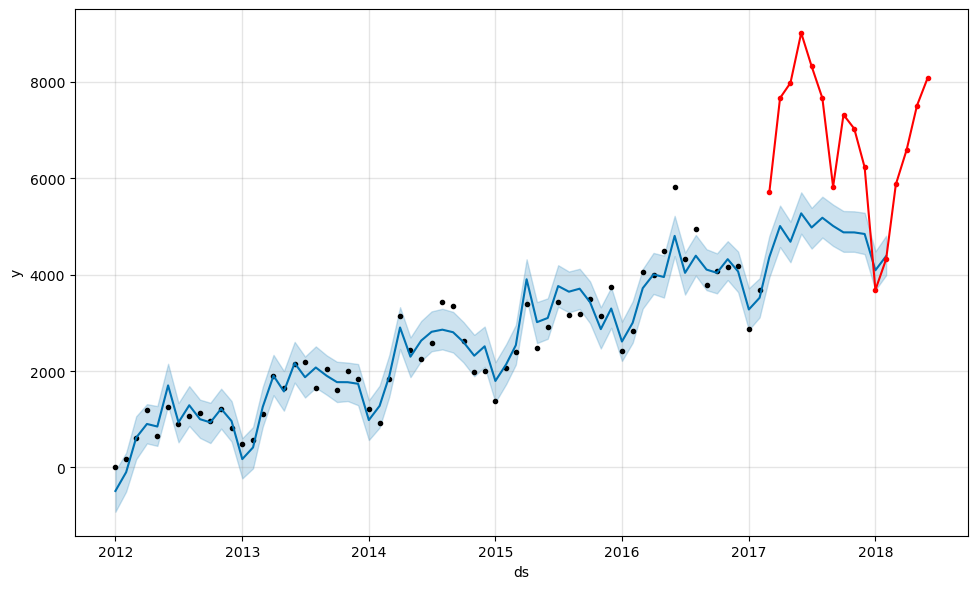

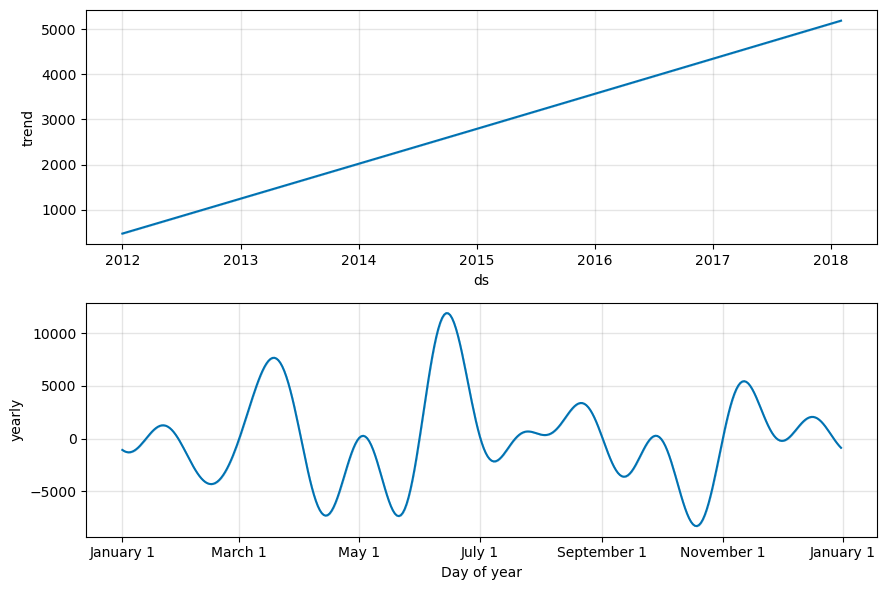

In [5]:
#Fit method allows to pass historical dataframe, first we need to describe 'ds' and 'y'
single_product_train['ds'] = single_product_train['date']

#model
m = Prophet()
m.fit(single_product_train[['ds', 'y']])

#Create a future dataframe with monthly frequency for the next 12 months
future = m.make_future_dataframe(periods=12, freq='MS')

#Make a prediction for the future dataframe
forecast = m.predict(future)
# print(forecast)

fig = m.plot(forecast)


plt.gca()
ax = fig.axes
ax[0].plot(single_product_validation['date'], single_product_validation['y'], marker='.', color='red')

fig = m.plot_components(forecast)



# Checking single channels vs. data from y_train_T2 file ('y')

Index(['key', 'date', 'channel_2', 'channel_15', 'channel_20', 'channel_29',
       'channel_43', 'channel_45', 'channel_52', 'channel_57', 'channel_75',
       'channel_89', 'channel_101', 'channel_111', 'y', 'ds'],
      dtype='object')


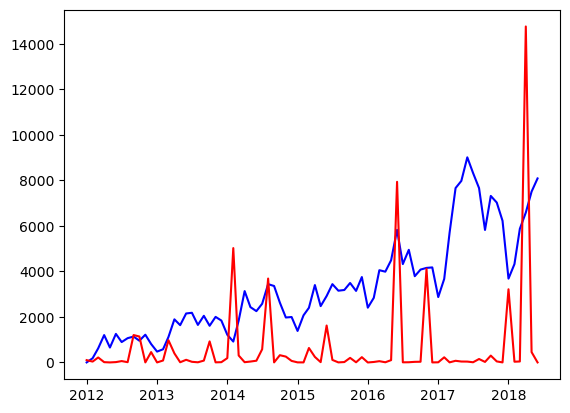

In [6]:
names_of_columns = data.columns
print(names_of_columns)

plt.plot(single_product['date'], single_product['y'], color='blue') 
plt.plot(single_product['date'], single_product['channel_111'], color = 'red')

# Add regressors

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      key       date  channel_2  channel_15   channel_20    channel_29  \
0   10873 2012-01-01   0.000000    0.855201     0.562593    102.682690   
1   10873 2012-02-01   1.035034   11.774970    19.115076   1205.408087   
2   10873 2012-03-01   0.000000    6.150736     3.034532    235.998029   
3   10873 2012-04-01   0.000000  154.188243    84.687752      7.956306   
4   10873 2012-05-01   0.000000    4.072811     0.213474    484.513722   
..    ...        ...        ...         ...          ...           ...   
57  10873 2016-10-01   0.000000    1.960576    10.927478  16885.035250   
58  10873 2016-11-01   4.305273  444.423615   114.894199     36.865041   
59  10873 2016-12-01   0.000000  854.860156  1783.719598   1007.816332   
60  10873 2017-01-01  14.910505  302.070873   269.543339    207.384509   
61  10873 2017-02-01   0.000000   62.360339   442.324661      5.198326   

     channel_43  channel_45  channel_52   channel_57  channel_75  channel_89  \
0    532.800200    0.000000    

C:\Users\Ania\anaconda3\envs\prophet-env\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Ania\anaconda3\envs\prophet-env\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Ania\anaconda3\envs\prophet-env\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Ania\anaconda3\envs\prophet-env\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

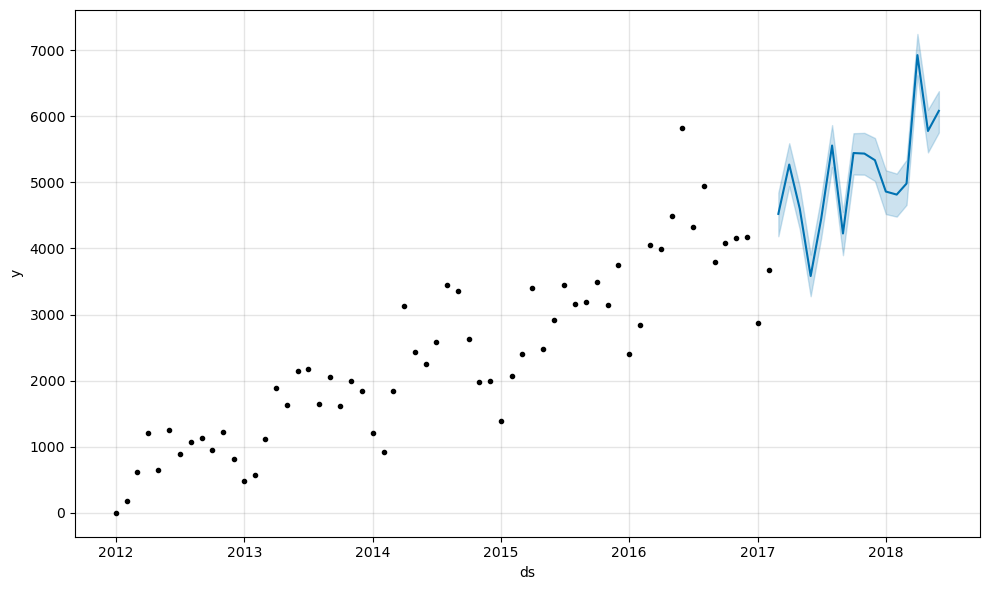

In [7]:
# Create a Prophet model object
model_channels = Prophet()
print(single_product_train) #minusy w danych przez ustawienie średniej. Co powinniśmy z nimi zrobić?

# Create a list of regressor column names
regressor_cols = list(single_product_train.columns[2:-2])

for channel in regressor_cols: 
    model_channels.add_regressor(channel)
    print(model_channels)
    
# Fit the model to the data, here we add selected channel 
model_channels.fit(single_product_train)

# Make predictions
forecast_channels = model_channels.predict(single_product_validation)


# Plot forecast
fig= model_channels.plot(forecast_channels)

ax[0].plot(single_product_train['date'], single_product_train['y'], marker='.', color='grey')
ax[0].plot(single_product_validation['date'], single_product_validation['y'], marker='.', color='red')
for channel in regressor_cols:
    ax[0].plot(single_product['date'], single_product[channel], marker='.', color='green')

#Saving plot
# plt.savefig(f'Prophet_{single_product}_{channel}_{date.today()}.png', dpi=100)
    

# Add regressor:channel_17
# model_channels.add_regressor('channel_15')

# # Fit the model to the data, here we add selected channel 
# model_channels.fit(single_product_train)

# # Make predictions
# forecast_channels = model_channels.predict(single_product_validation)

# # Plot forecast
# fig= model_channels.plot(forecast_channels)

# ax = fig.axes
# ax[0].plot(single_product_train['date'], single_product_train['y'], marker='.', color='grey')
# ax[0].plot(single_product_validation['date'], single_product_validation['y'], marker='.', color='red')
# ax[0].plot(single_product['date'], single_product['channel_15'], marker='.', color='green')

#TO DO:
#Dodaję metodę do odrzzucania channeli, które w 80% lub więcej mają NaNy DONE
#Dodaję kolejne regresory w pętli, ktora iteruje po channelach w dataframe (wyrzucić channele na etapie data)
#wypisać współczynniki regresorów, czy są istotne dla projekcji 